In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [149]:
df = pd.read_excel("train.xlsx")

In [150]:
df.head()

,RunDate,record_content_type,margin_regime_type,curr_notional_amt_usde
0,1985-09-04,107100102001,EU,2.953125
1,1985-09-05,107100102001,EU,2.976563
2,1985-09-06,107100102001,EU,2.992188
3,1985-09-09,107100102001,EU,2.945313
4,1985-09-10,107100102001,EU,2.875000


In [151]:
train, test = df.loc[df['RunDate'] <= '2013-09-03'], df.loc[df['RunDate'] > '2013-09-03']

In [152]:
train.shape, test.shape

((7059, 4), (1764, 4))

In [153]:
scaler = StandardScaler()
scaler = scaler.fit(train[['curr_notional_amt_usde']])

train['curr_notional_amt_usde'] = scaler.transform(train[['curr_notional_amt_usde']])
test['curr_notional_amt_usde'] = scaler.transform(test[['curr_notional_amt_usde']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [154]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['curr_notional_amt_usde']], train['curr_notional_amt_usde'])
X_test, y_test = create_sequences(test[['curr_notional_amt_usde']], test['curr_notional_amt_usde'])

In [155]:
print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (7029, 30, 1)
Testing shape: (1734, 30, 1)


In [156]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [157]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
198/198 [==============================] - 19s 76ms/step - loss: 0.0505 - val_loss: 0.0825
Epoch 2/100
198/198 [==============================] - 14s 73ms/step - loss: 0.0165 - val_loss: 0.0373
Epoch 3/100
198/198 [==============================] - 14s 72ms/step - loss: 0.0121 - val_loss: 0.0307
Epoch 4/100
198/198 [==============================] - 14s 72ms/step - loss: 0.0128 - val_loss: 0.0141
Epoch 5/100
198/198 [==============================] - 14s 72ms/step - loss: 0.0196 - val_loss: 0.0043
Epoch 6/100
198/198 [==============================] - 14s 72ms/step - loss: 0.0301 - val_loss: 0.0033
Epoch 7/100
198/198 [==============================] - 14s 73ms/step - loss: 0.0367 - val_loss: 0.0157
Epoch 8/100
198/198 [==============================] - 14s 72ms/step - loss: 0.0337 - val_loss: 0.0050
Epoch 9/100
198/198 [==============================] - 14s 73ms/step - loss: 0.0505 - val_loss: 0.0334


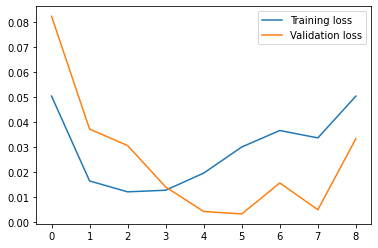

In [158]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [159]:
model.evaluate(X_test, y_test)

55/55 [==============================] - 1s 22ms/step - loss: 0.6979


0.697870671749115

Reconstruction error threshold: 1.4434469137644474


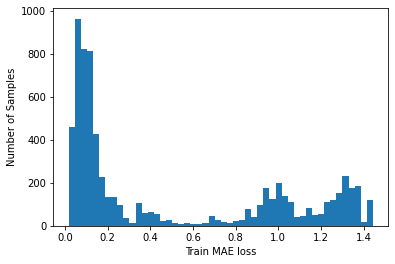

In [160]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')


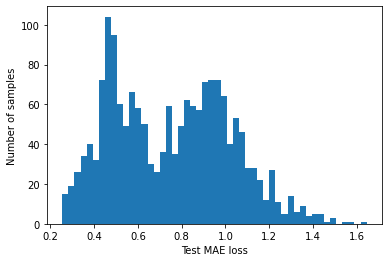

In [161]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [162]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['isnull_curr_notional_amt_usde']=test['curr_notional_amt_usde'].isnull()
test_score_df['isnull_record_content_type']=test['record_content_type'].isnull()
test_score_df['isnull_margin_regime_type']=test['margin_regime_type'].isnull()
test_score_df['anomaly'] = ((test_score_df['loss'] > test_score_df['threshold']) | (test_score_df['isnull_curr_notional_amt_usde'] | test_score_df['isnull_record_content_type'] | test_score_df['isnull_margin_regime_type']))
test_score_df['curr_notional_amt_usde'] = test[TIME_STEPS:]['curr_notional_amt_usde']

In [163]:
test_score_df.tail()

,RunDate,record_content_type,margin_regime_type,curr_notional_amt_usde,loss,threshold,isnull_curr_notional_amt_usde,isnull_record_content_type,isnull_margin_regime_type,anomaly
8818,2020-08-28,107100102001,EU,4.690756,1.142002,1.443447,False,False,False,False
8819,2020-08-31,107100102001,EU,4.650316,1.135862,1.443447,False,False,False,False
8820,2020-09-01,107100102001,EU,4.605024,1.141918,1.443447,False,False,False,False
8821,2020-09-02,107100102001,EU,4.698440,1.157452,1.443447,False,False,False,False
8822,2020-09-03,107100102001,EU,4.525357,1.149346,1.443447,False,False,False,False


In [164]:
test_score_df.loc[8747]

RunDate                          2020-05-19 00:00:00
record_content_type                     107100102001
margin_regime_type                                EU
curr_notional_amt_usde                       4.50392
loss                                          1.6459
threshold                                    1.44345
isnull_curr_notional_amt_usde                  False
isnull_record_content_type                     False
isnull_margin_regime_type                      False
anomaly                                         True
Name: 8747, dtype: object

In [165]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['RunDate'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['RunDate'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()